In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn

# Set seed for reproducibility
torch.manual_seed(0)
np.random.seed(0)
pd.set_option("display.max_columns", None)

In [6]:
# Technical indicators and feature list (same as before)
trend_indicators = ["DMN_10", "ADX_5", "ADX_7"]
oscillators = ["MACD_8_21_5", "STOCHk_7_3_3", "RSI_7"]
moving_averages = ["MA_20"]
volatility_indicators = ["Bollinger_Lower", "Bollinger_Upper"]
other_indicators = ["C3O3"]

mid_price_indicators = [
    "std_mid_price",
    "weighted_mid_price_variation",
    "mid_price_variation",
    "trade_close",
]
bid_ask_prices_indicators = ["std_spread", "mean_spread"]
volume_indicators = [
    "total_bid_volume",
    "total_ask_volume",
    "std_best_bid_size",
    "last_best_ask_size",
]
orders_indicators = [
    "mean_order_book_imbalance",
    "order_book_imbalance_5s",
    "order_flow_5s",
    "last_order_book_imbalance",
    "total_net_order_flow",
]

features = (
    trend_indicators
    + oscillators
    + moving_averages
    + volatility_indicators
    + other_indicators
    + mid_price_indicators
    + bid_ask_prices_indicators
    + volume_indicators
    + orders_indicators
)

In [7]:
# Parameters
sampling_rate = "1s"
prediction_column = "mean_mid_price_variation_class"
batch_size = 32
look_back = 16

In [8]:
from data_preprocessing import process_and_combine_data

# Load data (replace with your data loading logic)
start_date = "2024-10-03"
end_date = "2024-10-03"
all_data = process_and_combine_data(
    start_date, end_date, data_folder="AAPL_data", sampling_rate=sampling_rate
)

In [9]:
# Data splitting
train_size = int(len(all_data) * 0.7)
val_size = int(len(all_data) * 0.1)
test_size = len(all_data) - train_size - val_size

train_df = all_data.iloc[:train_size, :]
val_df = all_data.iloc[train_size : train_size + val_size, :]
test_df = all_data.iloc[train_size + val_size :, :]

In [10]:
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import MinMaxScaler

# Custom Dataset for PyTorch
class TimeSeriesDataset(Dataset):
    def __init__(self, data, target, features, look_back, scaler=None):
        self.data = data[features].values
        self.targets = data[target].values.astype(int)
        self.features = features
        self.look_back = look_back
        self.scaler = scaler if scaler else MinMaxScaler(feature_range=(0, 1))

    def __len__(self):
        return len(self.data) - self.look_back

    def __getitem__(self, idx):
        sequence = self.data[idx : idx + self.look_back]
        target = self.targets[idx + self.look_back]

        if self.scaler:
            sequence = self.scaler.fit_transform(sequence)

        return torch.tensor(sequence, dtype=torch.float32), torch.tensor(
            target, dtype=torch.long
        )

In [11]:
# Create datasets
train_dataset = TimeSeriesDataset(train_df, prediction_column, features, look_back)
val_dataset = TimeSeriesDataset(
    val_df, prediction_column, features, look_back, scaler=train_dataset.scaler
)
test_dataset = TimeSeriesDataset(
    test_df, prediction_column, features, look_back, scaler=train_dataset.scaler
)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [12]:
# Define the PyTorch model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, num_classes):
        super(LSTMModel, self).__init__()
        self.lstm1 = nn.LSTM(input_size, hidden_size1, batch_first=True)
        self.bn1 = nn.BatchNorm1d(hidden_size1)
        self.dropout1 = nn.Dropout(0.2)
        self.lstm2 = nn.LSTM(hidden_size1, hidden_size2, batch_first=True)
        self.bn2 = nn.BatchNorm1d(hidden_size2)
        self.dropout2 = nn.Dropout(0.2)
        self.fc1 = nn.Linear(hidden_size2, 32)
        self.dropout3 = nn.Dropout(0.2)
        self.fc2 = nn.Linear(32, num_classes)
    
    def forward(self, x):
        x, _ = self.lstm1(x)
        x = x.permute(0, 2, 1)  # Reshape for BatchNorm
        x = self.bn1(x)
        x = x.permute(0, 2, 1)
        x = self.dropout1(x)
        x, _ = self.lstm2(x)
        x = x.permute(0, 2, 1)
        x = self.bn2(x)
        x = x.permute(0, 2, 1)
        x = self.dropout2(x)
        x = x[:, -1, :]  # Take the last time step
        x = self.fc1(x)
        x = self.dropout3(x)
        x = self.fc2(x)
        return x

In [13]:
import torch.optim as optim

# Initialize model, loss, and optimizer
input_size = len(features)
hidden_size1 = 128
hidden_size2 = 64
num_classes = len(np.unique(all_data[prediction_column]))

model = LSTMModel(input_size, hidden_size1, hidden_size2, num_classes)
criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Replace SGD with Adam

In [14]:
# Training loop
num_epochs = 5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    correct_train = 0
    total_train = 0
    
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        optimizer.zero_grad()
        
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()

        # Accumulate training loss
        train_loss += loss.item()
        
        # Compute training accuracy
        _, predicted_train = torch.max(outputs.data, 1)
        total_train += batch_y.size(0)
        correct_train += (predicted_train == batch_y).sum().item()

    train_loss /= len(train_loader)
    train_acc = correct_train / total_train

    # Validation
    model.eval()
    val_loss = 0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            outputs = model(batch_X)
            val_loss += criterion(outputs, batch_y).item()
            _, predicted_val = torch.max(outputs.data, 1)
            total_val += batch_y.size(0)
            correct_val += (predicted_val == batch_y).sum().item()

    val_loss /= len(val_loader)
    val_acc = correct_val / total_val

    print(
        f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
        f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}"
    )


Epoch 1/5, Train Loss: 0.7057, Train Acc: 0.5054, Val Loss: 0.6909, Val Acc: 0.5282
Epoch 2/5, Train Loss: 0.6930, Train Acc: 0.5303, Val Loss: 0.6989, Val Acc: 0.5175
Epoch 3/5, Train Loss: 0.6895, Train Acc: 0.5426, Val Loss: 0.6828, Val Acc: 0.5567
Epoch 4/5, Train Loss: 0.6875, Train Acc: 0.5512, Val Loss: 0.6850, Val Acc: 0.5546
Epoch 5/5, Train Loss: 0.6850, Train Acc: 0.5584, Val Loss: 0.6821, Val Acc: 0.5682


Accuracy: 0.5438
              precision    recall  f1-score   support

           0       0.56      0.54      0.55      1443
           1       0.53      0.55      0.54      1376

    accuracy                           0.54      2819
   macro avg       0.54      0.54      0.54      2819
weighted avg       0.54      0.54      0.54      2819



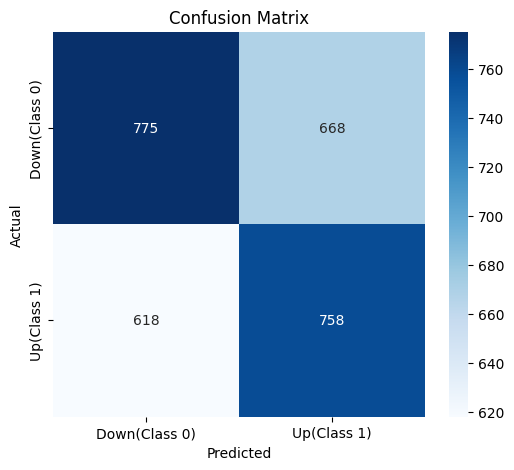

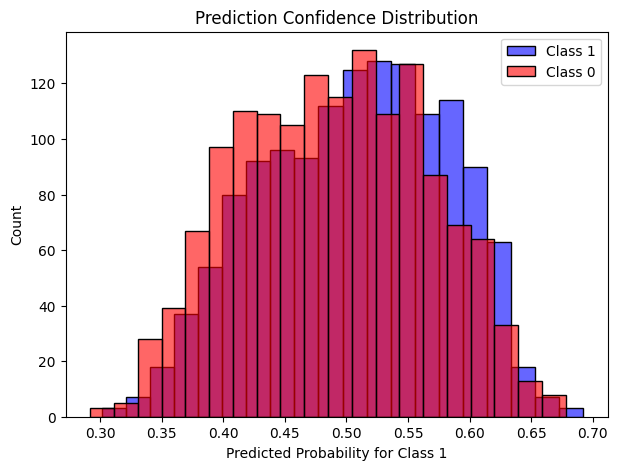

In [17]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

# Testing
model.eval()
all_predictions = []
true_labels = []
all_probs = []  # Store probabilities for confidence analysis

with torch.no_grad():
    for batch_X, batch_y in test_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        outputs = model(batch_X)
        
        # Get predicted class and probabilities
        probs = torch.softmax(outputs, dim=1)  # Convert logits to probabilities
        _, predicted = torch.max(outputs.data, 1)
        
        all_predictions.extend(predicted.cpu().numpy())
        true_labels.extend(batch_y.cpu().numpy())
        all_probs.extend(probs.cpu().numpy()[:, 1])  # Store probabilities for class 1

# Convert to numpy arrays
true_labels = np.array(true_labels)
all_predictions = np.array(all_predictions)
all_probs = np.array(all_probs)

print(f"Accuracy: {accuracy_score(true_labels, all_predictions):.4f}")
print(classification_report(true_labels, all_predictions, zero_division=0))

conf_matrix = confusion_matrix(true_labels, all_predictions)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Down(Class 0)", "Up(Class 1)"], yticklabels=["Down(Class 0)", "Up(Class 1)"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

plt.figure(figsize=(7, 5))
sns.histplot(all_probs[true_labels == 1], color="blue", label="Class 1", bins=20, alpha=0.6)
sns.histplot(all_probs[true_labels == 0], color="red", label="Class 0", bins=20, alpha=0.6)
plt.xlabel("Predicted Probability for Class 1")
plt.ylabel("Count")
plt.title("Prediction Confidence Distribution")
plt.legend()
plt.show()